Abrir un terminal y ejecutar paso a paso (no vale copiar y pegar, la terminal de Sagemaker sólo ejecuta el primer comando)

source /home/ec2-user/anaconda3/etc/profile.d/conda.sh

echo "Starting conda create command for rapidsai env"

conda create -y --solver=libmamba -n rapids-24.02 -c rapidsai -c conda-forge -c nvidia rapids=24.02 python=3.10 cuda-version=12.0 ipykernel

conda activate rapids-24.02

conda install ipykernel

python -m ipykernel install --user --name rapids-24.02 --display-name rapids-24.02


Si el notebook está abierto cerramos y volvemos a abrir, ya debería permitir usar el kernel.
Cuando se cierra el laboratorio el entorno conda se pierde.

## K-Means Demo

KMeans is a basic but powerful clustering method which is optimized via Expectation Maximization. It randomly selects K data points in X, and computes which samples are close to these points. For every cluster of points, a mean is computed, and this becomes the new centroid.

cuML’s KMeans supports the scalable KMeans++ initialization method. This method is more stable than randomnly selecting K points.

The model can take array-like objects, either in host as NumPy arrays or in device (as Numba or cuda_array_interface-compliant), as well as cuDF DataFrames as the input.

For information about cuDF, refer to the cuDF documentation.

For additional information on cuML's k-means implementation: https://docs.rapids.ai/api/cuml/stable/api.html#cuml.KMeans.

## Imports

In [1]:
import cudf
import cupy
import matplotlib.pyplot as plt
from cuml.cluster import KMeans as cuKMeans
from cuml.datasets import make_blobs
from sklearn.cluster import KMeans as skKMeans
from sklearn.metrics import adjusted_rand_score

%matplotlib inline

## Define Parameters

In [2]:
n_samples = 100000
n_features = 25

n_clusters = 8
random_state = 0

## Generate Data

In [3]:
device_data, device_labels = make_blobs(
    n_samples=n_samples,
    n_features=n_features,
    centers=n_clusters,
    random_state=random_state,
    cluster_std=0.1
)

In [4]:
# Copy CuPy arrays from GPU memory to host memory (NumPy arrays).
# This is done to later compare CPU and GPU results.
host_data = device_data.get()
host_labels = device_labels.get()

In [5]:
# Copy CuPy arrays from GPU memory to host memory (NumPy arrays).
# This is done to later compare CPU and GPU results.
host_data = device_data.get()
host_labels = device_labels.get()

## Scikit-learn model
### Fit

In [6]:
kmeans_sk = skKMeans(
    init="k-means++",
    n_clusters=n_clusters,
    random_state=random_state,
    n_init='auto'
)
%timeit kmeans_sk.fit(host_data)

118 ms ± 1.55 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


## cuML Model
### Fit

In [7]:
kmeans_cuml = cuKMeans(
    init="k-means||",
    n_clusters=n_clusters,
    random_state=random_state
)

%timeit kmeans_cuml.fit(device_data)

7.75 ms ± 116 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Visualize Centroids

Scikit-learn's k-means implementation uses the k-means++ initialization strategy while cuML's k-means uses k-means||. As a result, the exact centroids found may not be exact as the std deviation of the points around the centroids in make_blobs is increased.

Note: This is visualizing the centroids in only two dimensions.

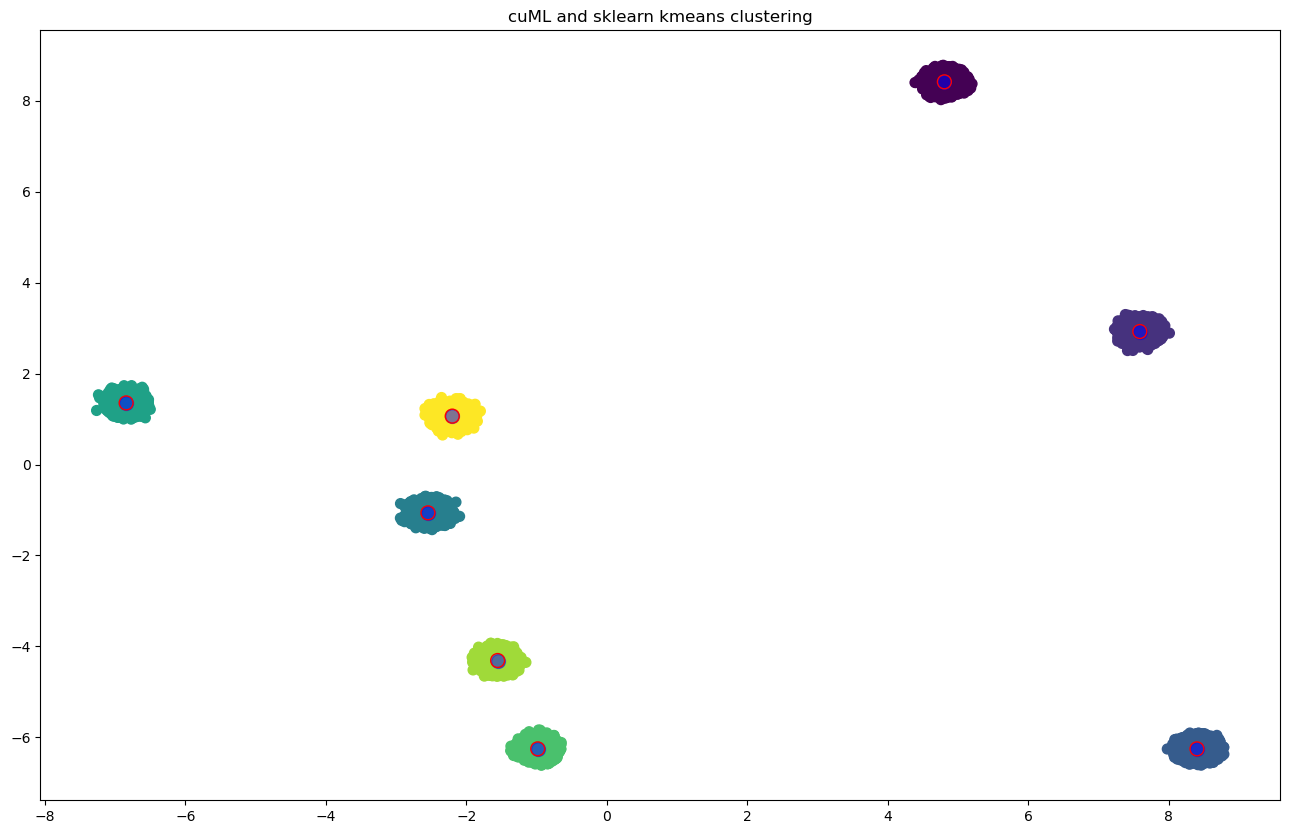

In [8]:
fig = plt.figure(figsize=(16, 10))
plt.scatter(host_data[:, 0], host_data[:, 1], c=host_labels, s=50, cmap='viridis')

#plot the sklearn kmeans centers with blue filled circles
centers_sk = kmeans_sk.cluster_centers_
plt.scatter(centers_sk[:,0], centers_sk[:,1], c='blue', s=100, alpha=.5)

#plot the cuml kmeans centers with red circle outlines
centers_cuml = kmeans_cuml.cluster_centers_
plt.scatter(cupy.asnumpy(centers_cuml[:, 0]), 
            cupy.asnumpy(centers_cuml[:, 1]), 
            facecolors = 'none', edgecolors='red', s=100)

plt.title('cuML and sklearn kmeans clustering')

plt.show()

## Compare Results

In [9]:
%%time
cuml_score = adjusted_rand_score(host_labels, kmeans_cuml.labels_.get())
sk_score = adjusted_rand_score(host_labels, kmeans_sk.labels_)

CPU times: user 31.1 ms, sys: 0 ns, total: 31.1 ms
Wall time: 30.6 ms


In [10]:
threshold = 1e-4

passed = (cuml_score - sk_score) < threshold
print('compare kmeans: cuml vs sklearn labels_ are ' + ('equal' if passed else 'NOT equal'))

compare kmeans: cuml vs sklearn labels_ are equal


In [11]:
from PIL import Image
import numpy as np
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt

In [12]:
# Implementación de K-means
def inicializar_centroides(X, k):
    indices = np.random.choice(X.shape[0], size=k, replace=False)
    return X[indices]

def asignar_grupos(X, centroides):
    distancias = cdist(X, centroides, 'hamming')
    return np.argmin(distancias, axis=1)

def actualizar_centroides(X, asignaciones, k):
    nuevos_centroides = np.array([X[asignaciones == i].mean(axis=0) for i in range(k)])
    return nuevos_centroides

def k_means(X, k, max_iteraciones=100, tolerancia=1e-4):
    centroides = inicializar_centroides(X, k)
    for _ in range(max_iteraciones):
        asignaciones = asignar_grupos(X, centroides)
        nuevos_centroides = actualizar_centroides(X, asignaciones, k)
        if np.all(np.abs(nuevos_centroides - centroides) < tolerancia):
            break
        centroides = nuevos_centroides
    return asignaciones, centroides

In [13]:
# Cargar la imagen con Pillow
#imagen = Image.open('playa.jpg')  # Asegúrate de proporcionar el path correcto a tu imagen
imagen = Image.open('Photographing-NYC-skyline.jpg')  # Asegúrate de proporcionar el path correcto a tu imagen
imagen_np = np.array(imagen) / 255.0  # Convertir a un array de Numpy y normalizar

# Preparar los datos para K-means
pixels = imagen_np.reshape(-1, 3)  # Redimensionar para que cada fila sea un píxel



In [14]:
# Aplicar K-means
k = 3  # Número de colores/clusters deseados
%timeit 
asignaciones, centroides = k_means(pixels, k)

/tmp/ipykernel_32043/3875745861.py:11: RuntimeWarning: Mean of empty slice.
  nuevos_centroides = np.array([X[asignaciones == i].mean(axis=0) for i in range(k)])
/home/ec2-user/SageMaker/.persisted_conda/rapids-24.02/lib/python3.10/site-packages/numpy/core/_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


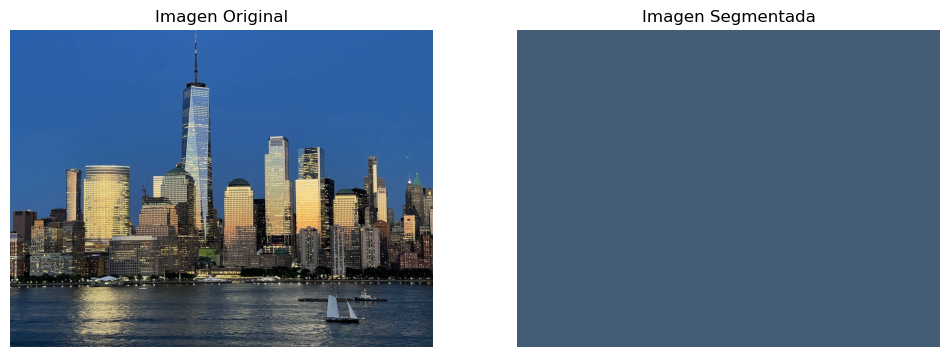

In [15]:
# Crear la imagen segmentada
imagen_segmentada = np.array([centroides[cluster_id] for cluster_id in asignaciones])
imagen_segmentada = imagen_segmentada.reshape(imagen_np.shape)  # Redimensionar a las dimensiones originales de la imagen

# Mostrar la imagen original y la segmentada
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.title('Imagen Original')
plt.imshow(imagen_np)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Imagen Segmentada')
plt.imshow(imagen_segmentada)
plt.axis('off')

plt.show()

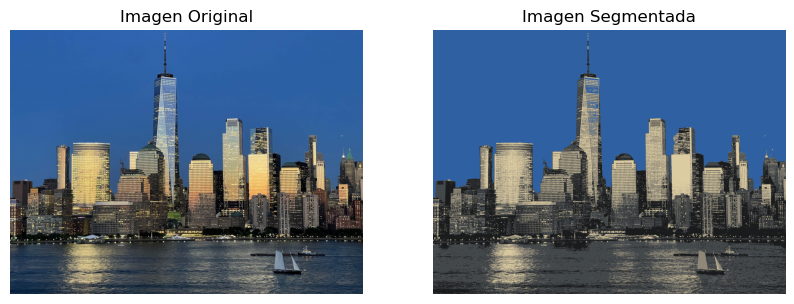

In [16]:
from sklearn.cluster import KMeans
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# Cargar y preparar la imagen
#image = Image.open('playa.jpg')
image = Image.open('Photographing-NYC-skyline.jpg')
image_np = np.array(image) / 255.0  # Normalizar los valores de los píxeles
pixels = image_np.reshape(-1, 3)  # Redimensionar la imagen a (num_pixels, 3)

# Aplicar K-means para segmentar por colores
kmeans_cuml = cuKMeans(n_clusters=5,random_state=42)
kmeans_cuml.fit(pixels)
labels = kmeans_cuml.predict(pixels)
new_pixels = kmeans_cuml.cluster_centers_[labels]

# Crear y mostrar la imagen segmentada
image_segmented = new_pixels.reshape(image_np.shape)
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image_np)
plt.title('Imagen Original')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(image_segmented)
plt.title('Imagen Segmentada')
plt.axis('off')

plt.show()

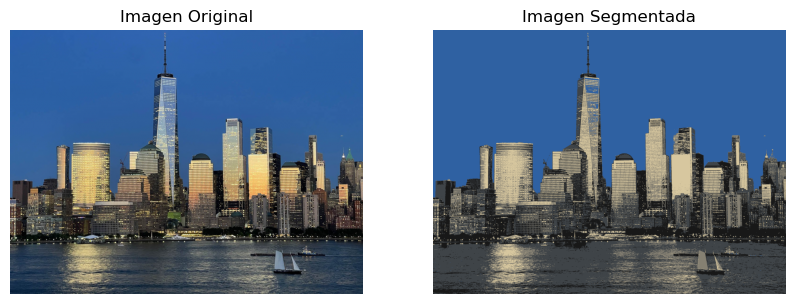

In [17]:
from sklearn.cluster import KMeans
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# Cargar y preparar la imagen
#image = Image.open('playa.jpg')
image = Image.open('Photographing-NYC-skyline.jpg')
image_np = np.array(image) / 255.0  # Normalizar los valores de los píxeles
pixels = image_np.reshape(-1, 3)  # Redimensionar la imagen a (num_pixels, 3)

# Aplicar K-means para segmentar por colores
kmeans = KMeans(n_clusters=5, random_state=42)
kmeans.fit(pixels)
labels = kmeans.predict(pixels)
new_pixels = kmeans.cluster_centers_[labels]

# Crear y mostrar la imagen segmentada
image_segmented = new_pixels.reshape(image_np.shape)
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image_np)
plt.title('Imagen Original')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(image_segmented)
plt.title('Imagen Segmentada')
plt.axis('off')

plt.show()

In [23]:
######cuML######

from cuml import RandomForestClassifier as cuRF
from sklearn.metrics import accuracy_score
from cuml import ForestInference
import sklearn.datasets

# cuml Random Forest params
cu_rf_params = {'n_estimators': 25,'max_depth': 13,'n_bins': 15,'n_streams': 8}

# Generate random sample data
X_test, y_test = sklearn.datasets.make_classification()

cu_rf = cuRF(**cu_rf_params)
cu_rf.fit(X_train, y_train)

print("cuml RF Accuracy Score: ", accuracy_score(cu_rf.predict(X_test), y_test))

NameError: name 'X_train' is not defined